In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
import PIL
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
from tqdm import tqdm
import tensorflow_addons as tfa
import random
from sklearn.preprocessing import MultiLabelBinarizer

pd.set_option("display.max_columns", None)

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

18632
Index(['image', 'labels'], dtype='object')
Axes(0.125,0.11;0.775x0.77)


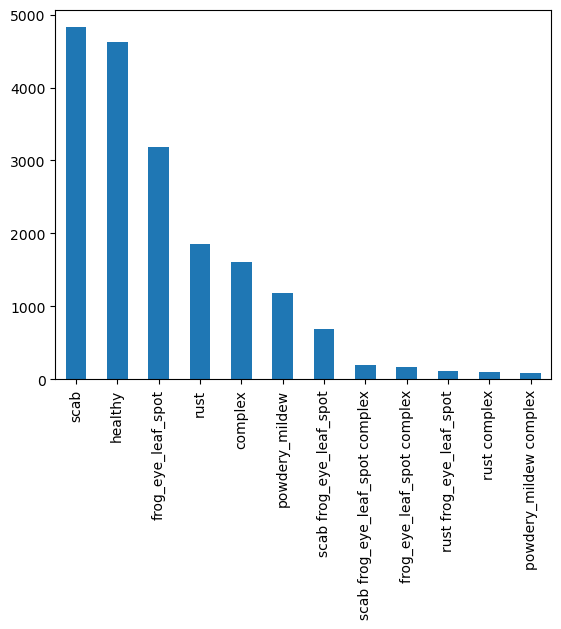

In [2]:
train = pd.read_csv('/kaggle/input/plant-pathology-2021-fgvc8/train.csv')
print(len(train))
print(train.columns)

print(train['labels'].value_counts().plot.bar())

In [3]:
train

,image,labels
0,800113bb65efe69e.jpg,healthy
1,8002cb321f8bfcdf.jpg,scab frog_eye_leaf_spot complex
2,80070f7fb5e2ccaa.jpg,scab
3,80077517781fb94f.jpg,scab
4,800cbf0ff87721f8.jpg,complex
...,...,...
18627,fffb900a92289a33.jpg,healthy
18628,fffc488fa4c0e80c.jpg,scab
18629,fffc94e092a59086.jpg,rust
18630,fffe105cf6808292.jpg,scab frog_eye_leaf_spot


In [4]:
train['labels'] = train['labels'].apply(lambda string: string.split(' '))
train

,image,labels
0,800113bb65efe69e.jpg,[healthy]
1,8002cb321f8bfcdf.jpg,"[scab, frog_eye_leaf_spot, complex]"
2,80070f7fb5e2ccaa.jpg,[scab]
3,80077517781fb94f.jpg,[scab]
4,800cbf0ff87721f8.jpg,[complex]
...,...,...
18627,fffb900a92289a33.jpg,[healthy]
18628,fffc488fa4c0e80c.jpg,[scab]
18629,fffc94e092a59086.jpg,[rust]
18630,fffe105cf6808292.jpg,"[scab, frog_eye_leaf_spot]"


In [5]:
train.shape

(18632, 2)

In [6]:
s = list(train['labels'])
mlb = MultiLabelBinarizer()
trainx = pd.DataFrame(mlb.fit_transform(s), columns=mlb.classes_, index=train.index)
print(trainx.columns)
print(trainx.sum())

Index(['complex', 'frog_eye_leaf_spot', 'healthy', 'powdery_mildew', 'rust',
       'scab'],
      dtype='object')
complex               2151
frog_eye_leaf_spot    4352
healthy               4624
powdery_mildew        1271
rust                  2077
scab                  5712
dtype: int64


In [7]:
2151+4352+4624+1271+2077+5712


20187

In [8]:
labels = list(trainx.sum().keys())
print(labels)

['complex', 'frog_eye_leaf_spot', 'healthy', 'powdery_mildew', 'rust', 'scab']


<Axes: >

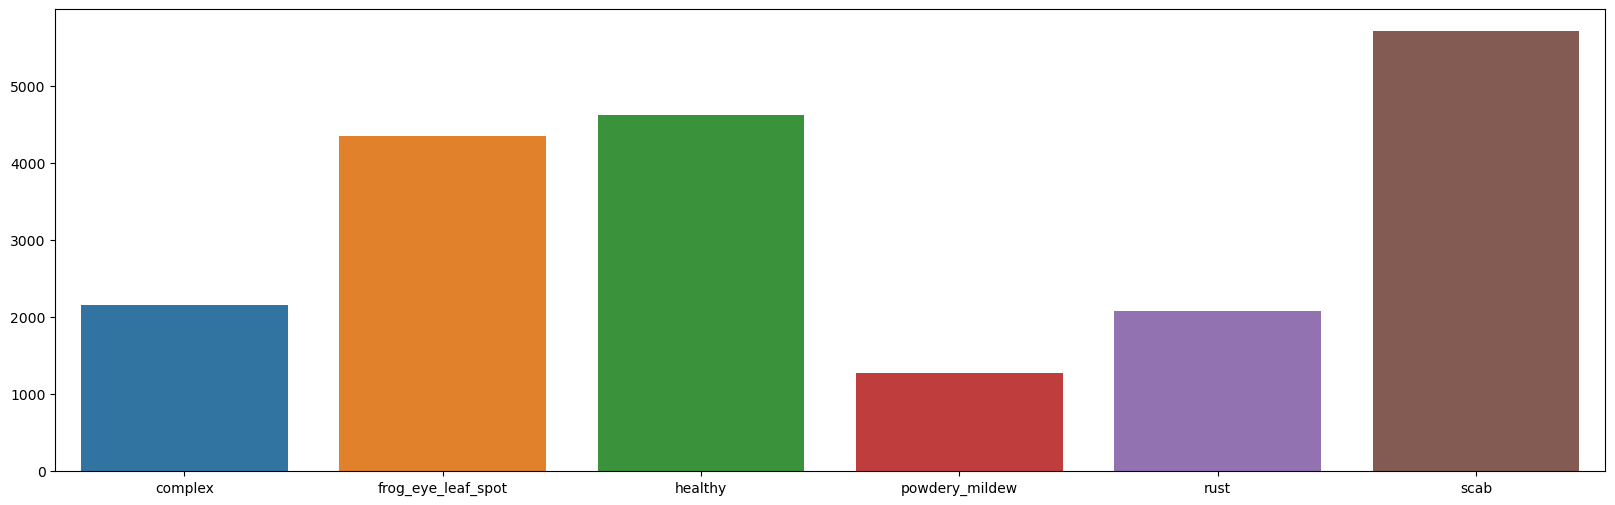

In [9]:
label_counts = trainx.sum().values.tolist()

fig, ax = plt.subplots(1,1, figsize=(20,6))
sns.barplot(x= labels, y= label_counts, ax=ax)

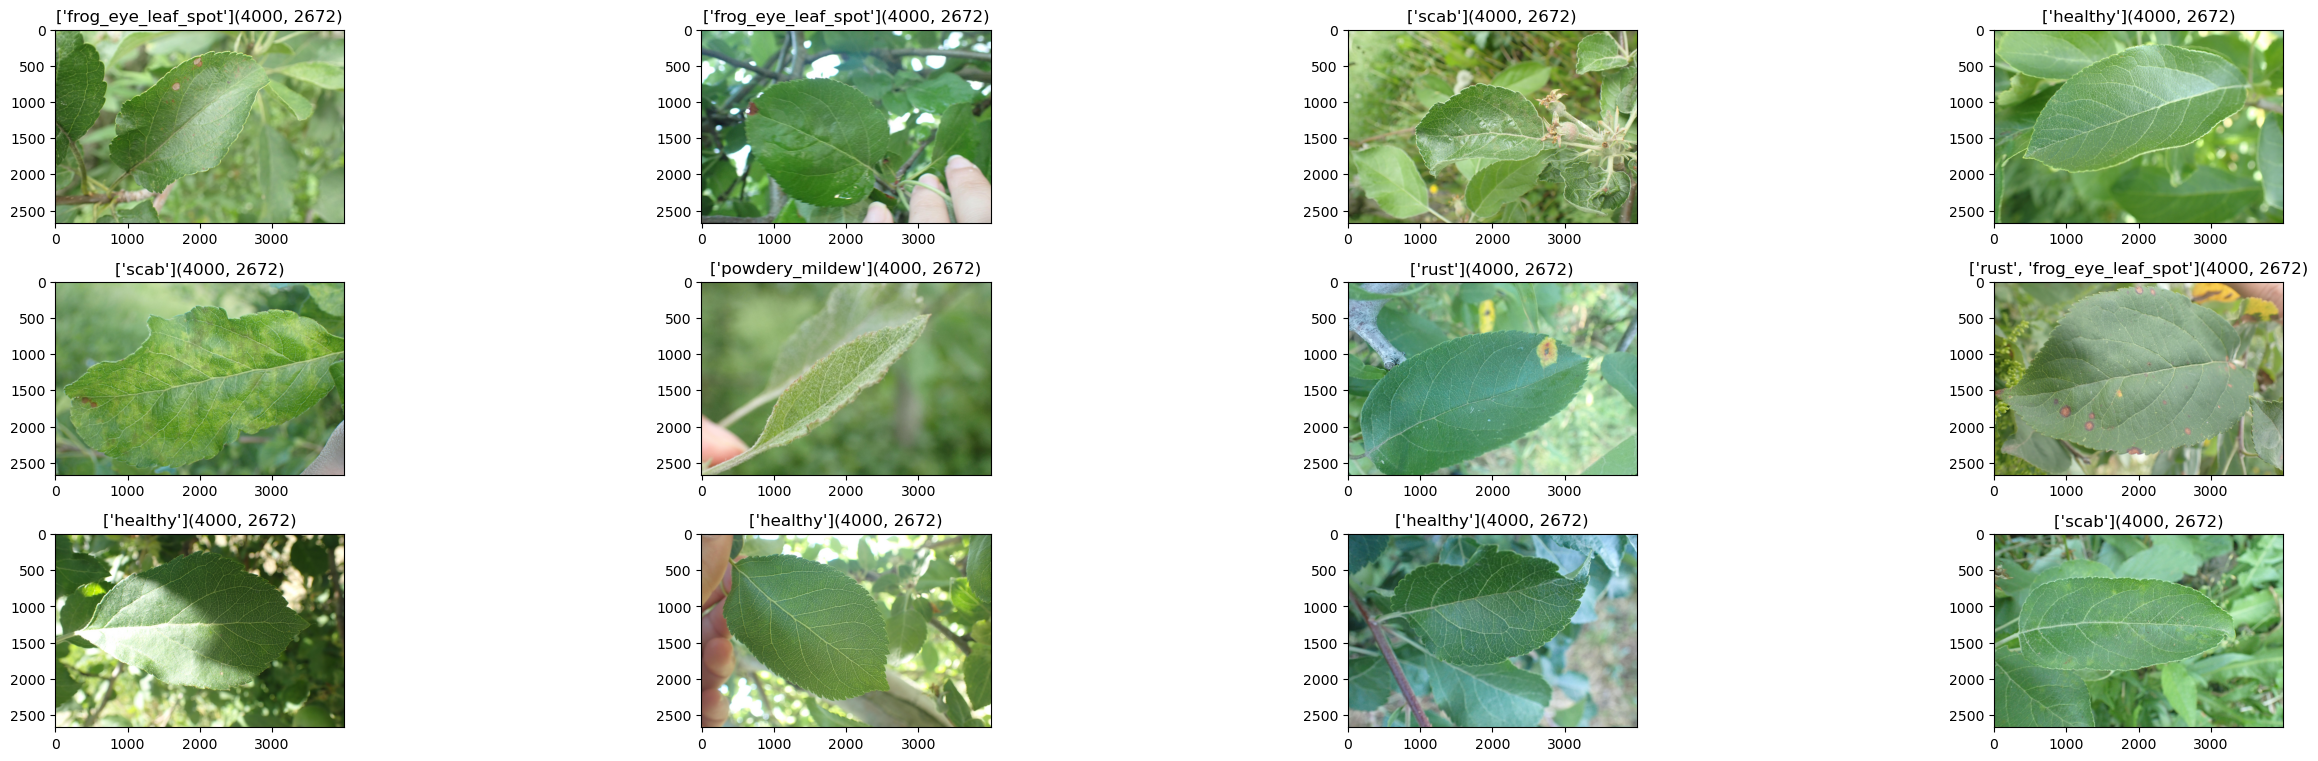

In [10]:
fig1 = plt.figure(figsize=(26,10))

for i in range(1, 13):
    
    rand =  random.randrange(1, 18000)
    sample = os.path.join('/kaggle/input/plant-pathology-2021-fgvc8/train_images', train['image'][rand])
    
    img = PIL.Image.open(sample)
    
    ax = fig1.add_subplot(4,4,i)
    ax.imshow(img)
    
    title = f"{train['labels'][rand]}{img.size}"
    plt.title(title)
    
    fig1.tight_layout()

In [11]:
datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1/255.0,
                                                        preprocessing_function=None,
                                                        data_format=None,
                                                    )

train_data = datagen.flow_from_dataframe(
    train,
    directory='/kaggle/input/plant-pathology-2021-fgvc8/train_images',
    x_col="image",
    y_col= 'labels',
    color_mode="rgb",
    target_size = (150,150),
    class_mode="categorical",
    batch_size=32,
    shuffle=False,
    seed=40,
)

Found 18632 validated image filenames belonging to 6 classes.


In [12]:
seed = 400
tf.random.set_seed(seed)

model = tf.keras.applications.MobileNet(input_shape=(150,150,3),include_top=False,weights="imagenet")

print(model.input)
print(model.output)

17225924/17225924 [==============================] - 2s 0us/step
KerasTensor(type_spec=TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")
KerasTensor(type_spec=TensorSpec(shape=(None, 4, 4, 1024), dtype=tf.float32, name=None), name='conv_pw_13_relu/Relu6:0', description="created by layer 'conv_pw_13_relu'")


In [13]:
new_model = tf.keras.Sequential([
    model,
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dense(6, 
        kernel_initializer=keras.initializers.RandomUniform(seed=seed),
        bias_initializer=keras.initializers.Zeros(), name='dense', activation='sigmoid')
])

In [14]:
# Freezing the weights
for layer in new_model.layers[:-2]:
    layer.trainable=False
    
new_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 4, 4, 1024)       3228864   
 nal)                                                            
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 6)                 6150      
                                                                 
Total params: 3,235,014
Trainable params: 6,150
Non-trainable params: 3,228,864
_________________________________________________________________


In [15]:
f1 = tfa.metrics.F1Score(num_classes=6, average='macro')

callbacks = keras.callbacks.EarlyStopping(monitor=f1, patience=3, mode='max', restore_best_weights=True)


new_model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=keras.optimizers.Adam(lr=1e-3), 
              metrics= [f1])

new_model.fit(train_data, verbose = 1,epochs=10, callbacks=callbacks)

Epoch 1/10
583/583 [==============================] - 1263s 2s/step - loss: 0.3133 - f1_score: 0.5822
Epoch 2/10
583/583 [==============================] - 1092s 2s/step - loss: 0.2645 - f1_score: 0.6713
Epoch 3/10
583/583 [==============================] - 1116s 2s/step - loss: 0.2531 - f1_score: 0.6886
Epoch 4/10
583/583 [==============================] - 1069s 2s/step - loss: 0.2461 - f1_score: 0.6984
Epoch 5/10
583/583 [==============================] - 1133s 2s/step - loss: 0.2418 - f1_score: 0.7043
Epoch 6/10
583/583 [==============================] - 1060s 2s/step - loss: 0.2396 - f1_score: 0.7077
Epoch 7/10
583/583 [==============================] - 1038s 2s/step - loss: 0.2371 - f1_score: 0.7129
Epoch 8/10
583/583 [==============================] - 1087s 2s/step - loss: 0.2357 - f1_score: 0.7143
Epoch 9/10
583/583 [==============================] - 1040s 2s/step - loss: 0.2344 - f1_score: 0.7186
Epoch 10/10
583/583 [==============================] - 1111s 2s/step - loss: 0.233

In [16]:
test = pd.read_csv('/kaggle/input/plant-pathology-2021-fgvc8/sample_submission.csv')

for img_name in tqdm(test['image']):
    path = '/kaggle/input/plant-pathology-2021-fgvc8/test_images/'+str(img_name)
    with PIL.Image.open(path) as img:
        img = img.resize((150,150))
        img.save(f'./{img_name}')

100%|██████████| 3/3 [00:00<00:00,  4.63it/s]


In [17]:
test_data = datagen.flow_from_dataframe(
    test,
    directory = './',
    x_col="image",
    y_col= None,
    color_mode="rgb",
    target_size = (150,150),
    classes=None,
    class_mode=None,
    batch_size=32,
    shuffle=False,
    seed=40,
)

preds = new_model.predict(test_data)
print(preds)
preds = preds.tolist()

indices = []
for pred in preds:
    temp = []
    for category in pred:
        if category>=0.3:
            temp.append(pred.index(category))
    if temp!=[]:
        indices.append(temp)
    else:
        temp.append(np.argmax(pred))
        indices.append(temp)
    
print(indices)

Found 3 validated image filenames.
1/1 [==============================] - 1s 1s/step
[[3.30830109e-04 6.54562414e-02 1.59734380e-04 1.13816530e-01
  4.17906977e-02 8.33618939e-01]
 [1.52083682e-02 1.13939956e-01 7.18452575e-05 1.88214937e-04
  2.13267352e-03 9.14154768e-01]
 [7.77275674e-03 3.84662241e-01 4.29505017e-04 6.98499614e-04
  9.86404344e-02 2.16185749e-02]]
[[5], [5], [1]]


In [18]:
labels = (train_data.class_indices)
labels = dict((v,k) for k,v in labels.items())
print(labels)

testlabels = []


for image in indices:
    temp = []
    for i in image:
        temp.append(str(labels[i]))
    testlabels.append(' '.join(temp))

print(testlabels)

{0: 'complex', 1: 'frog_eye_leaf_spot', 2: 'healthy', 3: 'powdery_mildew', 4: 'rust', 5: 'scab'}
['scab', 'scab', 'frog_eye_leaf_spot']


In [19]:
delfiles = tf.io.gfile.glob('./*.jpg')

for file in delfiles:
    os.remove(file)

In [20]:
sub = pd.read_csv('/kaggle/input/plant-pathology-2021-fgvc8/sample_submission.csv')
sub['labels'] = testlabels
sub.to_csv('submission.csv', index=False)
sub

,image,labels
0,85f8cb619c66b863.jpg,scab
1,ad8770db05586b59.jpg,scab
2,c7b03e718489f3ca.jpg,frog_eye_leaf_spot
